In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
!pip install torch-geometric
!pip install openpyxl
!pip install imbalanced-learn

In [53]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score
)
import matplotlib.pyplot as plt
import torch_geometric.nn as pyg_nn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [54]:
# Load node and edge data
nodes_df = pd.read_csv('/content/drive/MyDrive/MachineLearning/WW01_node.csv')
edges_df = pd.read_csv('/content/drive/MyDrive/MachineLearning/WW01_edge.csv')

In [55]:
# Load time-series data for flow rate and water depth
flow_rate_df = pd.read_excel('/content/drive/MyDrive/MachineLearning/WW01_v3/Flow_rate.xlsx')
water_depth_df = pd.read_excel('/content/drive/MyDrive/MachineLearning/WW01_v3/WW01_v3.xlsx')

In [56]:
# Preprocess data
flow_rate_df.columns = flow_rate_df.columns.astype(str)
water_depth_df.columns = water_depth_df.columns.astype(str)
flow_rate_df = flow_rate_df.apply(pd.to_numeric, errors='coerce').fillna(0)
water_depth_df = water_depth_df.apply(pd.to_numeric, errors='coerce').fillna(0)

In [57]:
scaler = MinMaxScaler()
flow_rate_scaled = scaler.fit_transform(flow_rate_df.iloc[:, 1:])
water_depth_scaled = scaler.fit_transform(water_depth_df.iloc[:, 1:])

In [58]:
# Binarize the target variable
threshold = 0.5  # Adjust this threshold as per your data
water_depth_balanced = (water_depth_scaled[:, -1] > threshold).astype(int)


In [59]:
# Align the datasets
min_samples = min(flow_rate_scaled.shape[0], water_depth_balanced.shape[0])
flow_rate_scaled = flow_rate_scaled[:min_samples]
water_depth_balanced = water_depth_balanced[:min_samples]

print("Aligned Flow Rate Shape:", flow_rate_scaled.shape)
print("Aligned Water Depth Shape:", water_depth_balanced.shape)

Aligned Flow Rate Shape: (434, 23)
Aligned Water Depth Shape: (434,)


In [60]:
# Apply SMOTE
smote = SMOTE(random_state=42)
flow_rate_balanced, water_depth_balanced = smote.fit_resample(flow_rate_scaled, water_depth_balanced)

print("Balanced Data Shapes:")
print("Flow Rate:", flow_rate_balanced.shape)
print("Water Depth:", water_depth_balanced.shape)

Balanced Data Shapes:
Flow Rate: (856, 23)
Water Depth: (856,)


In [61]:
unique, counts = np.unique(water_depth_balanced, return_counts=True)
print("Class Distribution After SMOTE:", dict(zip(unique, counts)))


Class Distribution After SMOTE: {0: 428, 1: 428}


In [62]:
# Prepare PyTorch datasets
train_data, test_data, train_labels, test_labels = train_test_split(
    flow_rate_balanced, water_depth_balanced, test_size=0.2, random_state=42
)

train_dataset = TensorDataset(
    torch.tensor(train_data, dtype=torch.float32),
    torch.tensor(train_labels, dtype=torch.float32)
)
test_dataset = TensorDataset(
    torch.tensor(test_data, dtype=torch.float32),
    torch.tensor(test_labels, dtype=torch.float32)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [63]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTM weights and biases
        self.W_i = nn.Parameter(torch.randn(hidden_size, input_size))
        self.W_f = nn.Parameter(torch.randn(hidden_size, input_size))
        self.W_c = nn.Parameter(torch.randn(hidden_size, input_size))
        self.W_o = nn.Parameter(torch.randn(hidden_size, input_size))

        self.U_i = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.U_f = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.U_c = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.U_o = nn.Parameter(torch.randn(hidden_size, hidden_size))

        self.b_i = nn.Parameter(torch.zeros(hidden_size))
        self.b_f = nn.Parameter(torch.zeros(hidden_size))
        self.b_c = nn.Parameter(torch.zeros(hidden_size))
        self.b_o = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c = torch.zeros(batch_size, self.hidden_size, device=x.device)

        for t in range(seq_len):
            x_t = x[:, t, :]
            i_t = torch.sigmoid(x_t @ self.W_i.T + h @ self.U_i.T + self.b_i)
            f_t = torch.sigmoid(x_t @ self.W_f.T + h @ self.U_f.T + self.b_f)
            o_t = torch.sigmoid(x_t @ self.W_o.T + h @ self.U_o.T + self.b_o)
            c_tilde = torch.tanh(x_t @ self.W_c.T + h @ self.U_c.T + self.b_c)
            c = f_t * c + i_t * c_tilde
            h = o_t * torch.tanh(c)

        return h





# Manual GNN Implementation
class CustomGNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomGNN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W = nn.Parameter(torch.randn(out_channels, in_channels))  # Learnable weights
        self.b = nn.Parameter(torch.zeros(out_channels))  # Learnable bias

    def forward(self, x, edge_index):
        # Initialize output node features
        out = torch.zeros(x.size(0), self.out_channels, device=x.device)

        # Aggregate messages from neighbors
        row, col = edge_index
        for i in range(x.size(0)):  # For each node
            neighbors = col[row == i]
            if len(neighbors) > 0:
                neighbor_features = x[neighbors]  # Get features of neighboring nodes
                aggregated_message = neighbor_features.mean(dim=0)  # Mean aggregation
                out[i] = torch.matmul(self.W, aggregated_message) + self.b  # Update feature
            else:
                out[i] = torch.matmul(self.W, x[i]) + self.b  # Self-loop for isolated nodes

        return F.relu(out)  # Apply non-linearity


class HybridModel(nn.Module):
    def __init__(self, lstm_hidden_size, gnn_hidden_size, num_features, num_classes):
        super(HybridModel, self).__init__()
        self.lstm = CustomLSTM(input_size=num_features, hidden_size=lstm_hidden_size)
        self.gnn = CustomGNN(in_channels=num_features, out_channels=gnn_hidden_size)
        self.fc = nn.Linear(lstm_hidden_size + gnn_hidden_size, num_classes)

    def forward(self, lstm_input, gnn_input, edge_index, batch):
        # LSTM Forward Pass
        lstm_out = self.lstm(lstm_input)  # Shape: [batch_size, lstm_hidden_size]

        # GNN Forward Pass
        gnn_out = self.gnn(gnn_input, edge_index)  # Node-level output: [num_nodes, gnn_hidden_size]

        # Pool GNN output to graph level
        gnn_out_pooled = global_mean_pool(gnn_out, batch)  # Graph-level output: [batch_size, gnn_hidden_size]

        # Concatenate LSTM and GNN outputs
        combined = torch.cat((lstm_out, gnn_out_pooled), dim=1)  # Shape: [batch_size, lstm_hidden_size + gnn_hidden_size]

        # Final Classification Layer
        return self.fc(combined)



In [64]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Configuration
lstm_hidden_size = 64
gnn_hidden_size = 64
num_features = flow_rate_balanced.shape[1]  # Number of input features
num_classes = 1  # Binary classification

# Initialize the Hybrid Model
hybrid_model = HybridModel(
    lstm_hidden_size=lstm_hidden_size,
    gnn_hidden_size=gnn_hidden_size,
    num_features=num_features,
    num_classes=num_classes
).to(device)  # Ensure model is moved to the selected device

# Debugging Model Initialization
print(hybrid_model)


HybridModel(
  (lstm): CustomLSTM()
  (gnn): CustomGNN()
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [65]:
# Training configuration
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=0.001)

In [66]:
# Map node IDs to integers in edges_df and nodes_df
node_mapping = {node: idx for idx, node in enumerate(set(edges_df['Inlet Node']).union(edges_df['Outlet Node']))}
edges_df['Inlet Node'] = edges_df['Inlet Node'].map(node_mapping)
edges_df['Outlet Node'] = edges_df['Outlet Node'].map(node_mapping)
nodes_df[' Node ID'] = nodes_df[' Node ID'].map(node_mapping)

# Prepare node_features
node_features = torch.tensor(flow_rate_scaled, dtype=torch.float)

# Add padding if necessary
num_nodes = len(node_mapping)
if node_features.size(0) < num_nodes:
    padding = torch.zeros((num_nodes - node_features.size(0), node_features.size(1)))
    node_features = torch.cat([node_features, padding], dim=0)

# Prepare edge_index
edge_index = torch.tensor(
    list(zip(edges_df['Inlet Node'], edges_df['Outlet Node'])),
    dtype=torch.long
).t().contiguous()

# Ensure edge_index is valid
assert edge_index.max().item() < node_features.size(0), "edge_index contains invalid node indices!"

print("Max index in edge_index:", edge_index.max().item())
print("Number of rows in node_features:", node_features.size(0))


Max index in edge_index: 38
Number of rows in node_features: 434


In [67]:
# Create a mapping from unique nodes in edges_df
node_mapping = {node: idx for idx, node in enumerate(set(edges_df['Inlet Node']).union(edges_df['Outlet Node']))}

# Map node IDs in edges_df
edges_df['Inlet Node'] = edges_df['Inlet Node'].map(node_mapping)
edges_df['Outlet Node'] = edges_df['Outlet Node'].map(node_mapping)

# Map node IDs in nodes_df (for node_features)
nodes_df[' Node ID'] = nodes_df[' Node ID'].map(node_mapping)


In [68]:
# Prepare node_features tensor
node_features = torch.tensor(flow_rate_scaled, dtype=torch.float)

# Extend node_features if necessary
num_nodes = len(node_mapping)
if node_features.size(0) < num_nodes:
    padding = torch.zeros((num_nodes - node_features.size(0), node_features.size(1)))
    node_features = torch.cat([node_features, padding], dim=0)

print("Updated number of rows in node_features:", node_features.size(0))


Updated number of rows in node_features: 434


In [69]:
# Convert edges to tensor format
edge_index = torch.tensor(
    list(zip(edges_df['Inlet Node'], edges_df['Outlet Node'])),
    dtype=torch.long
).t().contiguous()

# Validate edge_index
assert edge_index.max().item() < node_features.size(0), "edge_index contains invalid node indices!"


In [70]:
# Assuming X and y are the input features and target labels
X_train, X_val, y_train, y_val = train_test_split(flow_rate_balanced, water_depth_balanced, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [71]:
# Define input size (number of features in train_data)
input_size = flow_rate_balanced.shape[1]

# Training with validation
best_hybrid_model = None
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(50):  # Adjust number of epochs
    hybrid_model.train()
    train_loss = 0
    for train_data, train_labels in train_loader:
        # Reshape and move to device
        train_data = train_data.view(train_data.size(0), -1, input_size).to(device)  # Shape: [32, 1, 23]
        train_labels = train_labels.to(device)

        # Debugging shapes

        # Create batch tensor for GNN
        batch = torch.arange(train_data.size(0), device=device).repeat_interleave(
            node_features.size(0) // train_data.size(0)
        )
        if node_features.size(0) % train_data.size(0) > 0:
            extra_batch = torch.arange(node_features.size(0) % train_data.size(0), device=device)
            batch = torch.cat((batch, extra_batch))

        optimizer.zero_grad()
        try:
            # Forward pass
            outputs = hybrid_model(train_data, node_features.to(device), edge_index, batch)

            loss = criterion(outputs.squeeze(), train_labels.float())  # Adjust for output shape
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        except RuntimeError as e:
            print("RuntimeError during training: ", e)
            break

    train_loss /= len(train_loader)

    # Validation phase
    hybrid_model.eval()
    test_loss = 0
    with torch.no_grad():
        for test_data, test_labels in test_loader:
            # Reshape and move to device
            test_data = test_data.view(test_data.size(0), -1, input_size).to(device)  # Shape: [32, 1, 23]
            test_labels = test_labels.to(device)

            # Create batch tensor for GNN
            batch = torch.arange(test_data.size(0), device=device).repeat_interleave(
                node_features.size(0) // test_data.size(0)
            )
            if node_features.size(0) % test_data.size(0) > 0:
                extra_batch = torch.arange(node_features.size(0) % test_data.size(0), device=device)
                batch = torch.cat((batch, extra_batch))

            try:
                # Debugging shapes before validation
                # Forward pass
                outputs = hybrid_model(test_data, node_features.to(device), edge_index, batch)

                # Ensure outputs align with test_labels
                loss = criterion(outputs.squeeze(), test_labels.float())  # Adjust for output shape
                test_loss += loss.item()
            except RuntimeError as e:
                print("RuntimeError during validation: ", e)
                break

    test_loss /= len(test_loader)
    print("Epoch {}: Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch + 1, train_loss, test_loss))


    # Early stopping logic
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        best_hybrid_model = hybrid_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model
hybrid_model.load_state_dict(best_hybrid_model)


Epoch 1: Train Loss: 0.6903, Test Loss: 0.6699
Epoch 2: Train Loss: 0.6561, Test Loss: 0.6342
Epoch 3: Train Loss: 0.6217, Test Loss: 0.5955
Epoch 4: Train Loss: 0.5816, Test Loss: 0.5502
Epoch 5: Train Loss: 0.5431, Test Loss: 0.5070
Epoch 6: Train Loss: 0.4950, Test Loss: 0.4609
Epoch 7: Train Loss: 0.4569, Test Loss: 0.4180
Epoch 8: Train Loss: 0.4089, Test Loss: 0.3761
Epoch 9: Train Loss: 0.3672, Test Loss: 0.3389
Epoch 10: Train Loss: 0.3318, Test Loss: 0.3054
Epoch 11: Train Loss: 0.3023, Test Loss: 0.2744
Epoch 12: Train Loss: 0.2661, Test Loss: 0.2465
Epoch 13: Train Loss: 0.2455, Test Loss: 0.2221
Epoch 14: Train Loss: 0.2226, Test Loss: 0.2003
Epoch 15: Train Loss: 0.1986, Test Loss: 0.1818
Epoch 16: Train Loss: 0.1796, Test Loss: 0.1655
Epoch 17: Train Loss: 0.1626, Test Loss: 0.1515
Epoch 18: Train Loss: 0.1550, Test Loss: 0.1390
Epoch 19: Train Loss: 0.1424, Test Loss: 0.1282
Epoch 20: Train Loss: 0.1303, Test Loss: 0.1195
Epoch 21: Train Loss: 0.1238, Test Loss: 0.1108
E

<All keys matched successfully>

In [72]:
# Evaluation mode
hybrid_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.view(x_batch.size(0), -1, input_size).to(device)
        y_batch = y_batch.to(device)

        # Generate batch tensor for evaluation
        num_nodes = node_features.size(0)
        batch = torch.arange(x_batch.size(0), device=device).repeat_interleave(num_nodes // x_batch.size(0))
        if num_nodes % x_batch.size(0) > 0:
            extra_batch = torch.arange(num_nodes % x_batch.size(0), device=device)
            batch = torch.cat((batch, extra_batch))

        # Get predictions
        outputs = hybrid_model(x_batch, node_features.to(device), edge_index, batch)
        preds = (torch.sigmoid(outputs) > 0.5).long().cpu().numpy()
        labels = y_batch.cpu().numpy()

        all_preds.extend(preds.flatten())
        all_labels.extend(labels.flatten())

In [73]:
# Metrics calculation
hybrid_model_accuracy = accuracy_score(all_labels, all_preds)
hybrid_model_precision = precision_score(all_labels, all_preds, zero_division=0)
hybrid_model_recall = recall_score(all_labels, all_preds)
hybrid_model_f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print("Accuracy: {:.4f}".format(hybrid_model_accuracy))
print("Precision: {:.4f}".format(hybrid_model_precision))
print("Recall: {:.4f}".format(hybrid_model_recall))
print("F1 Score: {:.4f}".format(hybrid_model_f1))

print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9826
Precision: 1.0000
Recall: 0.9643
F1 Score: 0.9818
Confusion Matrix:
[[88  0]
 [ 3 81]]


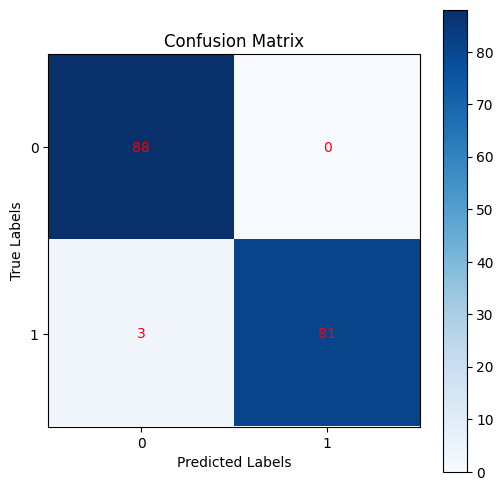

In [74]:
# Plot confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks([0, 1])
plt.yticks([0, 1])

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='red')

plt.show()

In [75]:
# Data Preprocessing for base line models

X = flow_rate_balanced
y = water_depth_balanced

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten features for scikit-learn models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Ensure labels are in the correct format
y_train = y_train.ravel() if len(y_train.shape) > 1 else y_train
y_test = y_test.ravel() if len(y_test.shape) > 1 else y_test


In [76]:
# Initialize models
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
svm_model = SVC(kernel='linear', random_state=42, probability=True)

In [77]:
# Train Logistic Regression
logistic_model.fit(X_train_flat, y_train)
y_pred_logistic = logistic_model.predict(X_test_flat)

# Train SVM
svm_model.fit(X_train_flat, y_train)
y_pred_svm = svm_model.predict(X_test_flat)

In [78]:
#Compute Metrics for Logistic Regression
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic)
recall_logistic = recall_score(y_test, y_pred_logistic)
roc_auc_logistic = roc_auc_score(y_test, y_pred_logistic)

# Compute Metrics for SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)


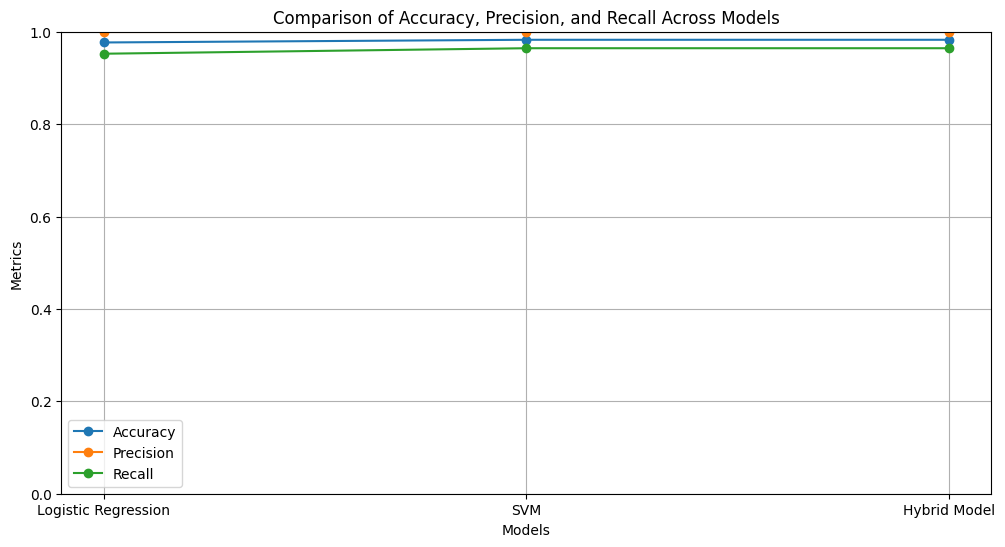

In [79]:
# Example data for baseline models
model_names = ['Logistic Regression', 'SVM', 'Hybrid Model']

# Ensure all metrics are scalars
accuracy = [
    float(accuracy_logistic),
    float(accuracy_svm),
    float(hybrid_model_accuracy)
]

precision = [
    float(precision_logistic),
    float(precision_svm),
    float(hybrid_model_precision)
]

recall = [
    float(recall_logistic),
    float(recall_svm),
    float(hybrid_model_recall)
]

# Plotting Accuracy, Precision, and Recall
plt.figure(figsize=(12, 6))

# Accuracy
plt.plot(model_names, accuracy, marker='o', label='Accuracy')

# Precision
plt.plot(model_names, precision, marker='o', label='Precision')

# Recall
plt.plot(model_names, recall, marker='o', label='Recall')

# Adding titles and labels
plt.title('Comparison of Accuracy, Precision, and Recall Across Models')
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.legend()
plt.show()


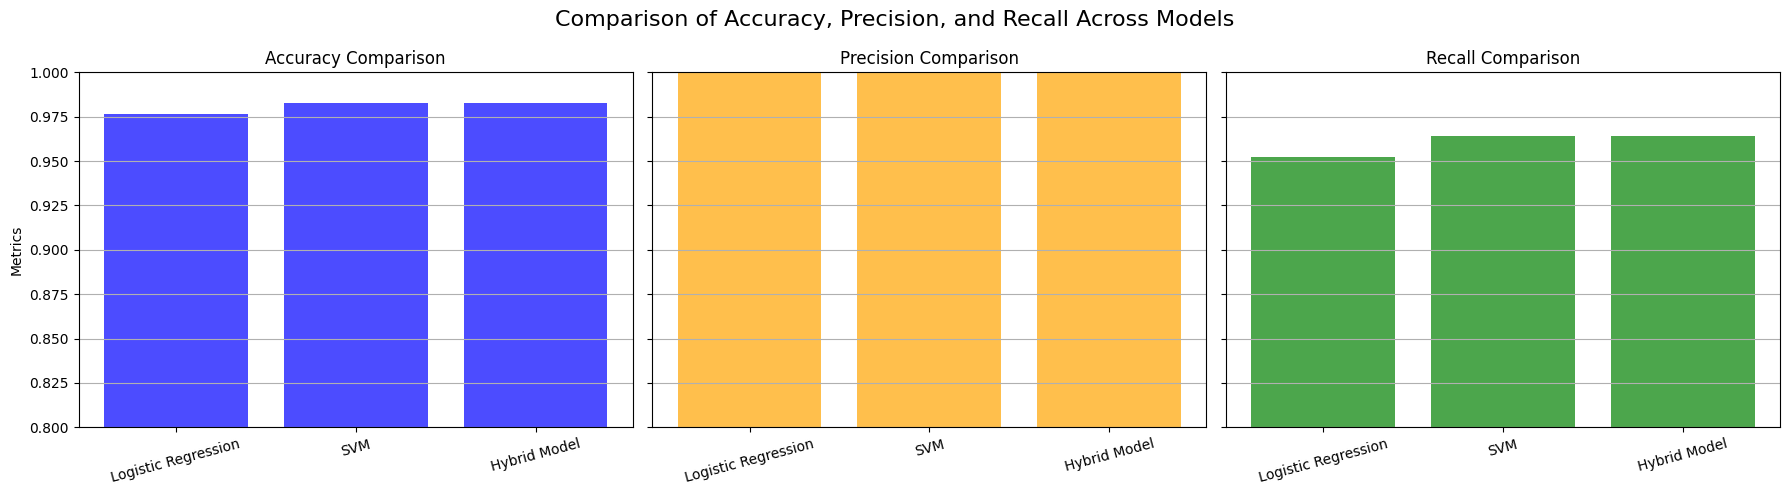

In [80]:
# Example data for baseline models
model_names = ['Logistic Regression', 'SVM', 'Hybrid Model']

# Metrics
accuracy = [
    float(accuracy_logistic),
    float(accuracy_svm),
    float(hybrid_model_accuracy)
]

precision = [
    float(precision_logistic),
    float(precision_svm),
    float(hybrid_model_precision)
]

recall = [
    float(recall_logistic),
    float(recall_svm),
    float(hybrid_model_recall)
]

# Creating bar chart for better visualization
x = np.arange(len(model_names))  # Model indices

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Accuracy
ax[0].bar(x, accuracy, color='blue', alpha=0.7, label='Accuracy')
ax[0].set_title('Accuracy Comparison')
ax[0].set_xticks(x)
ax[0].set_xticklabels(model_names, rotation=15)
ax[0].set_ylabel('Metrics')
ax[0].set_ylim(0.8, 1.0)  # Adjust to focus on the range of values
ax[0].grid(axis='y')

# Precision
ax[1].bar(x, precision, color='orange', alpha=0.7, label='Precision')
ax[1].set_title('Precision Comparison')
ax[1].set_xticks(x)
ax[1].set_xticklabels(model_names, rotation=15)
ax[1].grid(axis='y')

# Recall
ax[2].bar(x, recall, color='green', alpha=0.7, label='Recall')
ax[2].set_title('Recall Comparison')
ax[2].set_xticks(x)
ax[2].set_xticklabels(model_names, rotation=15)
ax[2].grid(axis='y')

# Final adjustments
plt.suptitle('Comparison of Accuracy, Precision, and Recall Across Models', fontsize=16)
plt.tight_layout()
plt.show()
